In [105]:
from sys import path
path.append('../src/')

import numpy as np
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt

from os.path import split, join
from keras import backend as K
from keras.models import load_model
from keras.activations import linear, sigmoid
from keras.utils import to_categorical
from tensorflow.python.platform import gfile

from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

%matplotlib inline

print(tf.__version__)

1.13.1


In [2]:
TEST_SIZE = 0.1

PATH_TO_ROOT = "../"

FILE_MODEL = join(PATH_TO_ROOT, "models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5")
FILE_SAMPLES = join(PATH_TO_ROOT, "data/unsupervised_supervised_samples.pkl")

print(FILE_MODEL)
print(FILE_SAMPLES)

../models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5
../data/unsupervised_supervised_samples.pkl


# Data Loading 

In [3]:
x_train, x_val, train_mrks, val_mrks = pkl.load(open(FILE_SAMPLES, 'rb'))
y_train = np.array([mrk_file.photo_reqs.values() for mrk_file in train_mrks])
y_val = np.array([mrk_file.photo_reqs.values() for mrk_file in val_mrks])

x_train /= 255
x_val /= 255

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(5151, 160, 160, 3) float32
(5151, 23) int32
(580, 160, 160, 3) float32
(580, 23) int32


# Original Model 

In [4]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'fbeta': fbeta,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

model = load_model(FILE_MODEL, custom_objects=custom_objects)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0

In [5]:
y_pred_sigmoid = model.predict(x_val)[1]
y_pred_sigmoid[0]

array([0.6480917 , 0.9347415 , 0.9957387 , 0.08281669, 0.991169  ,
       0.99987257, 0.97726715, 0.2788375 , 0.96358013, 0.05340791,
       0.20580041, 0.14253011, 0.98283845, 0.471276  , 0.8292504 ,
       0.9903073 , 0.7546122 , 0.9796298 , 0.8930521 , 0.6584908 ,
       0.9751569 , 0.82795393, 0.9905076 ], dtype=float32)

In [6]:
model.layers[-1].activation = linear
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[])

model.save("model_temperature_scaling.h5")
model = load_model("model_temperature_scaling.h5")

y_pred_linear = model.predict(x_val)[1]
print(y_pred_linear[0])
print(K.get_session().run(sigmoid(y_pred_linear[0])))

[ 0.6106614   2.6619136   5.453908   -2.4046774   4.72062     8.967512
  3.7609484  -0.95023555  3.2755404  -2.8749096  -1.3504281  -1.7944325
  4.0477705  -0.11502278  1.5803238   4.626631    1.1233641   3.873102
  2.1223032   0.656576    3.6700191   1.5711955   4.647724  ]
[0.6480917  0.9347415  0.9957387  0.08281669 0.991169   0.99987257
 0.97726715 0.2788375  0.96358013 0.05340791 0.20580041 0.14253011
 0.98283845 0.471276   0.8292504  0.9903073  0.7546122  0.97962976
 0.8930521  0.65849084 0.9751569  0.827954   0.9905076 ]


# Temperature Scaling 

In [60]:
def build_graph():
    tf.reset_default_graph()
    
    graph = tf.Graph()
    with graph.as_default():
        temp = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32, name="temp") 

        y_pred = tf.placeholder(dtype=tf.float32, shape=(None, ), name="y_pred")
        y_req = tf.placeholder(dtype=tf.float32, shape=(None, ), name="y_req")

        y_temp = tf.math.divide(y_pred, temp)
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_req, logits=y_temp)
        loss = tf.reduce_mean(cross_entropy, name="loss")
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss, name="optimizer")
    return graph

In [62]:
N_REQS = y_val.shape[1]
N_EPOCHS = 500

list_temperatures = []
sess = K.get_session()
for i in range(N_REQS):
    print(f"Req: {i + 1}")
    
    graph = build_graph()
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        temp = graph.get_tensor_by_name("temp:0")
        print(f"Temperature Initial value: {temp.eval()}")
        
        y_pred = graph.get_tensor_by_name("y_pred:0")
        y_req = graph.get_tensor_by_name("y_req:0")
        feed_dict = {
            y_pred: y_pred_linear[:, i],
            y_req: y_val[:, i]
        }
        
        loss = graph.get_tensor_by_name("loss:0")
        optimizer = graph.get_operation_by_name("optimizer")
        for epoch in range(N_EPOCHS):
            _, cost = sess.run([optimizer, loss], feed_dict=feed_dict)
        print(f"Temperature   Final value: {temp.eval()}")
        print(f"       Loss   Final value: {cost}", end="\n\n")
        list_temperatures.append(temp.eval())

Req: 1
Temperature Initial value: 1.0
Temperature   Final value: 0.7202396392822266
       Loss   Final value: 0.10995595902204514

Req: 2
Temperature Initial value: 1.0
Temperature   Final value: 1.6149886846542358
       Loss   Final value: 0.20009152591228485

Req: 3
Temperature Initial value: 1.0
Temperature   Final value: 1.2930761575698853
       Loss   Final value: 0.0392523817718029

Req: 4
Temperature Initial value: 1.0
Temperature   Final value: 1.2171709537506104
       Loss   Final value: 0.22822286188602448

Req: 5
Temperature Initial value: 1.0
Temperature   Final value: 0.9226481914520264
       Loss   Final value: 0.10753940045833588

Req: 6
Temperature Initial value: 1.0
Temperature   Final value: 0.8168065547943115
       Loss   Final value: 0.010461423546075821

Req: 7
Temperature Initial value: 1.0
Temperature   Final value: 0.7754143476486206
       Loss   Final value: 0.1820015162229538

Req: 8
Temperature Initial value: 1.0
Temperature   Final value: 1.4967334270

In [63]:
print(np.array(list_temperatures))

[0.72023964 1.6149887  1.2930762  1.217171   0.9226482  0.81680655
 0.77541435 1.4967334  1.7468733  1.5217109  1.1665096  1.3844513
 1.8485     1.0221235  0.7438692  1.1263908  1.0265276  0.16541567
 1.7934476  1.6463976  0.45624524 1.2901064  1.1938468 ]


In [68]:
K.clear_session()

model = load_model("model_temperature_scaling.h5")
y_pred_linear = model.predict(x_val)[1]
print(y_pred_linear[0])
print(K.get_session().run(sigmoid(y_pred_linear[0])))

[ 0.6106614   2.6619136   5.453908   -2.4046774   4.72062     8.967512
  3.7609484  -0.95023555  3.2755404  -2.8749096  -1.3504281  -1.7944325
  4.0477705  -0.11502278  1.5803238   4.626631    1.1233641   3.873102
  2.1223032   0.656576    3.6700191   1.5711955   4.647724  ]
[0.6480917  0.9347415  0.9957387  0.08281669 0.991169   0.99987257
 0.97726715 0.2788375  0.96358013 0.05340791 0.20580041 0.14253011
 0.98283845 0.471276   0.8292504  0.9903073  0.7546122  0.97962976
 0.8930521  0.65849084 0.9751569  0.827954   0.9905076 ]


In [69]:
print(K.get_session().run(sigmoid(y_pred_linear[0] / list_temperatures)))

[0.7001177  0.8386551  0.9854826  0.12178564 0.9940381  0.99998295
 0.99223435 0.34640646 0.8670459  0.13132873 0.23909172 0.2148166
 0.8993261  0.47189635 0.8932584  0.98381704 0.7491969  1.
 0.7655523  0.5983982  0.9996791  0.7716903  0.9800244 ]


In [72]:
val_mrks[0].filepath

'..\\data/cropped_faces/ground_truth/afwDB_0.mrk'

# Reliability Diagrams 

In [149]:
def reliability(y_true, y_prob, thresh_values=np.arange(0, 1.1, 0.1)):
    list_probs, list_freqs = [], []
    for t_from, t_end in zip(thresh_values[:-1], thresh_values[1:]):
        mask_prob = np.where((y_prob >= t_from) & (y_prob < t_end))
        y_true_t = y_true[mask_prob]
        y_prob_t = y_prob[mask_prob]
        
        avg_prob = np.mean(y_prob_t)
        rel_freq = np.mean(y_true_t == 1)
        
        list_probs.append(avg_prob)
        list_freqs.append(rel_freq)
    return list_probs, list_freqs

In [150]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

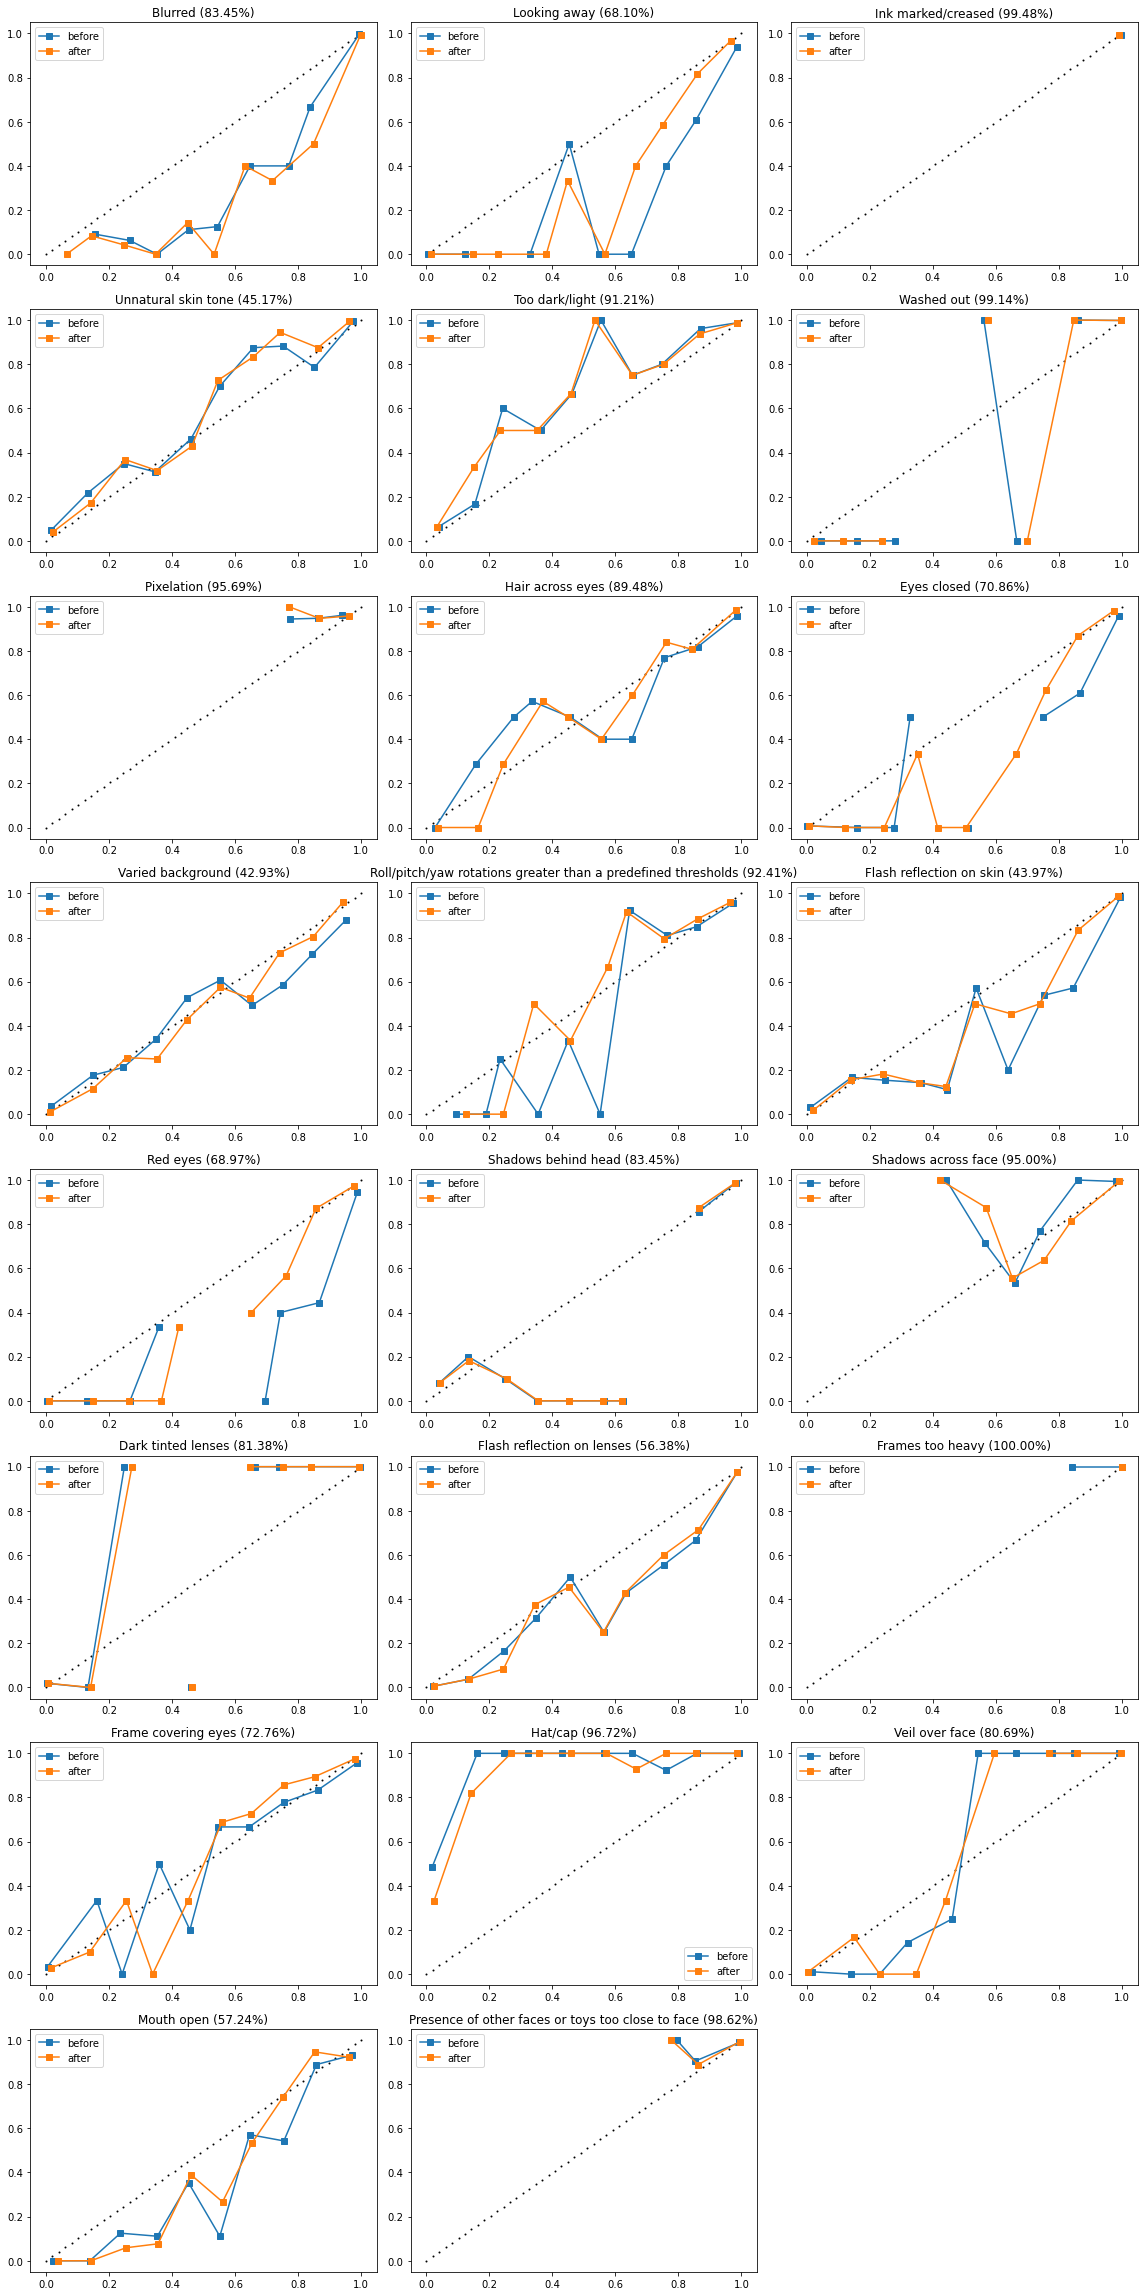

In [151]:
list_req_names = [req.description for req in val_mrks[0].photo_reqs]
perfect = np.linspace(0, 1, 50)

plt.figure(figsize=(16, 32))
for i, req in enumerate(list_req_names):
    y_true = y_val[:, i]
    y_pred = y_pred_sigmoid[:, i]
    probs_bef, freqs_bef = reliability(y_true, y_pred)

    y_pred = sigmoid(y_pred_linear[:, i] / list_temperatures[i])
    probs_after, freqs_after = reliability(y_true, y_pred)
    
    pos_freq = np.mean(y_true)
    plt.subplot(8, 3, i + 1)
    plt.scatter(perfect, perfect, c="black", s=1)
    plt.plot(probs_bef, freqs_bef, marker='s', label="before")
    plt.plot(probs_after, freqs_after, marker='s', label="after")
    plt.title(f"{req} ({pos_freq * 100:.2f}%)")
    plt.legend()
    
plt.tight_layout()